# DeepRacer Generalization with Static Image Evaluation

Prompted by Amazon DeepRacer team's "Sim2Real" paper (https://arxiv.org/abs/1911.01562).

Typical evaluation of DeepRacer training sessions are to simulate laps on a track in RoboMaker, the same environment as training except for running in inference mode.

This notebook is an attempt to create a "fast" analysis of model training checkpoints.  Having a fast analysis would:

1. To save time in training evaluations
1. To give deeper insight into maturity of a model to avoid overfitting
1. To evaluate a variety of environments vs. the single one in the simulator



In [90]:
import itertools
import json
import math
import cv2
from PIL import Image
from PIL import ImageEnhance
from PIL import ImageFilter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import s3_models
import skimage
import skimage.exposure
import tensorflow as tf
from tensorflow.python.platform import gfile

In [7]:
# Image helper functions

def rgb2gray(rgb):
    """Convert RGB numpy array of shape (x,y,3) to (x,y,1) grayscale """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def image_to_npy(image_path):
    """Load an image by path (png, jpg) as a numpy array"""
    img = Image.open(image_path)
    img_arr = np.array(img)
    img_arr = rgb2gray(img_arr)
    img_arr = np.expand_dims(img_arr, axis=2)
    return img_arr

def image_grid(image_paths):
    """Show a set of images in a nice 2d layout"""
    plt.figure(1, figsize=(20,20))
    n_columns = 5
    n_rows = math.ceil(len(eval_images) / n_columns) + 1
    for i in range(len(image_paths)):
        plt.subplot(n_rows, n_columns, i+1)
        image_path = image_paths[i]
        plt.title(image_path)
        image = np.array(Image.open(image_path))
        plt.imshow(image, interpolation="nearest", cmap="gray")

In [27]:
# Functions to load a .pb tensorflow graph and run an image through it

def load_session(pb_path):
    """Load a tensorflow .pb file into a new session"""
    # allow_soft_placement will avoid errors when loading the graph without a GPU
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, 
                                    log_device_placement=False))
    #print("load graph:", pb_path)
    with gfile.FastGFile(pb_path,'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    sess.graph.as_default()  # set this as the default graph for the session
    tf.import_graph_def(graph_def, name='')
    observation_tensor = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/observation/observation:0')
    policy_tensor = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')    
    return sess, observation_tensor, policy_tensor

# Run inference, returning the action probabilities
def analyze_image(model, observation_tensor, policy_tensor, image_path):
    """Run inference on an image to get action probabilities"""
    img_arr = image_to_npy(image_path)
    # Note that the input image should already be scaled as expected by the network observation layer
    return model.run(policy_tensor, feed_dict={observation_tensor:[img_arr]})[0]

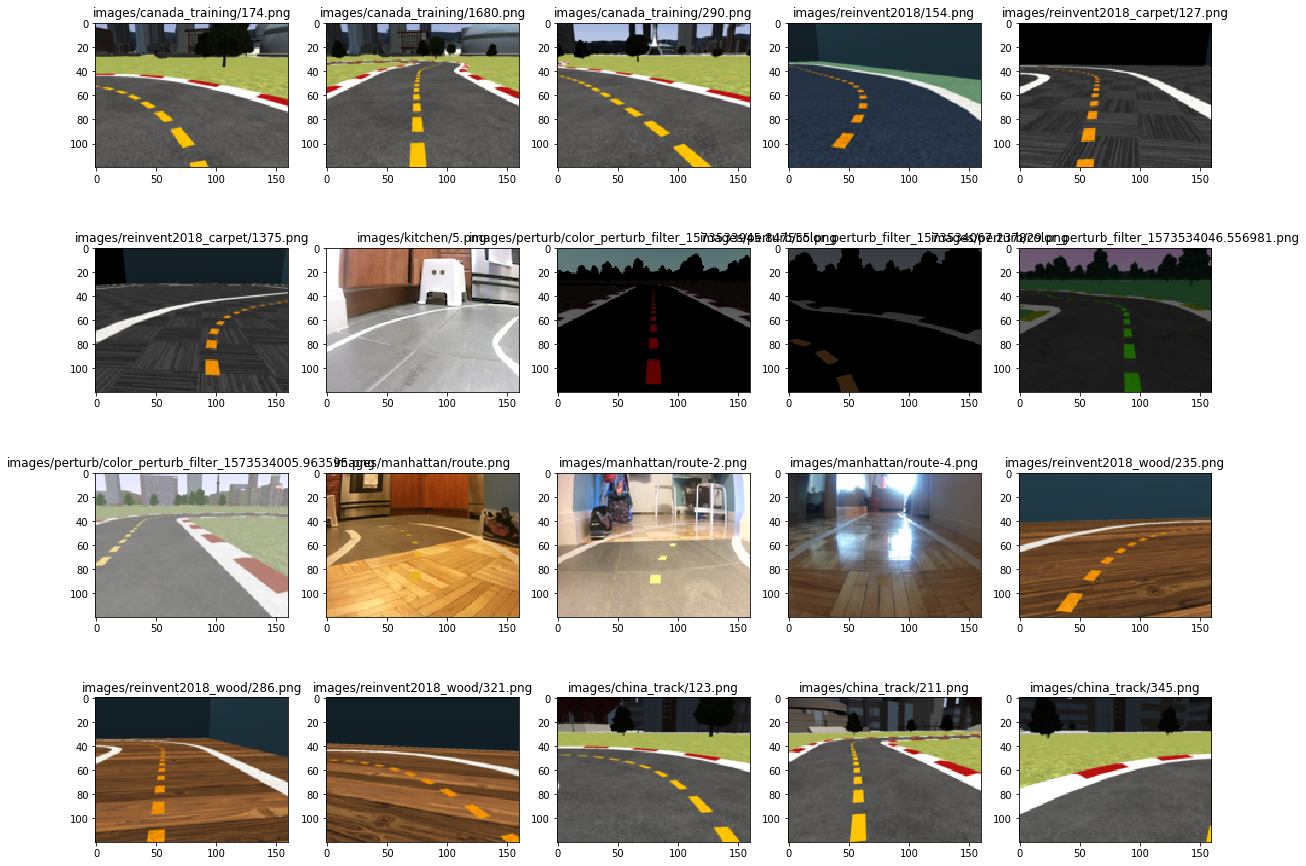

In [28]:
# Our list of manually tagged images with their corresponding expected actions

# Categorization
LEFT=0
STRAIGHT=1
RIGHT=2

# Selection of various track images to 
eval_images = np.array([
    ['images/canada_training/174.png', LEFT],
    ['images/canada_training/1680.png', STRAIGHT],
    ['images/canada_training/290.png',LEFT],
    ['images/reinvent2018/154.png', LEFT],
    ['images/reinvent2018_carpet/127.png', STRAIGHT],
    ['images/reinvent2018_carpet/1375.png', RIGHT],
    ['images/kitchen/5.png', RIGHT],
    ['images/perturb/color_perturb_filter_1573533945.847555.png', STRAIGHT], # hue and contrast
    ['images/perturb/color_perturb_filter_1573534067.237829.png', LEFT], # brightness
    ['images/perturb/color_perturb_filter_1573534046.556981.png', STRAIGHT], # hue and brightness
    ['images/perturb/color_perturb_filter_1573534005.963595.png', STRAIGHT], # brightness
    ['images/manhattan/route.png', LEFT], # transition in flooring: light->dark
    ['images/manhattan/route-2.png', RIGHT], # transition in flooring: dark->light
    ['images/manhattan/route-4.png', STRAIGHT], # heavy reflections
    ['images/reinvent2018_wood/235.png', RIGHT],
    ['images/reinvent2018_wood/286.png', STRAIGHT],
    ['images/reinvent2018_wood/321.png', LEFT],
    ['images/china_track/123.png', LEFT],
    ['images/china_track/211.png', STRAIGHT],
    ['images/china_track/345.png', RIGHT]
])

image_grid(eval_images[:,0:1].flatten())

# Run Offline Evaluation

Here we run the image evaluation.  "Offline" is referring to not using the Gazebo/ROS simulation and rather just running single images through the graph.

### Key Metrics

The key outputs of evaluation are:

1. Action correctness (categoreis are left, straight, right)
2. Confidence (i.e. softmax)

### Interpretation of Metrics

- As training progresses, a good model should be increasing correctness along with confidence.

- Overfitted models will show poor or flat correctness as confidence rises during the training session.

- Good generalized models should have increasing correctness as confidence rises.

In [65]:
# This code finds the checkpoint files stored by SageMaker
# in S3.

s3_bucket='aws-deepracer-b6c3c104-eef5-4878-a257-d981cd204d62'

# nero session1
#job_id='20191121194910-d7442c81-7966-4ed3-bf23-22d93fcfbed3'
# nero session1a
#job_id='20191122140743-8e69f32d-3ed4-4ef9-ab78-1c338bcdb59f'
# nero session1b
#job_id='20191124123204-f86d7945-d893-43fe-ae92-9be63442f736'
# nero session1c
#job_id='20191124225016-bdc2909c-e270-47e2-84d3-97084b68ef12'
# nero session1d
#job_id='20191125220919-8e5a9da1-9d2d-410f-8c51-fd19bf7d75d6'
# nero session1e
#job_id='20191126232543-1d063616-b927-4eab-8fe1-e3627a955d20'

# galba session1
#job_id='20191128021150-74c993f8-98d8-46d0-be59-e6736942d664'
# galba session2
#job_id='20191128052645-ff18cb68-cbcd-4448-8ac0-41513cbfba73'


s3_prefix='training-jobs/%s/shared/model' % job_id
log_path='models/%s' % job_id

print("Available checkpoints to load")
available_checkpoints = s3_models.list_available_checkpoints(s3_bucket, s3_prefix, log_path)
available_checkpoints = sorted(available_checkpoints, key=lambda name: int(name[6:].split('.')[0])) # sort numerically
print("%d checkpoints available for %s (%s is latest)" % (len(available_checkpoints), job_id, available_checkpoints[-1]))

Available checkpoints to load
14 checkpoints available for 20191128052645-ff18cb68-cbcd-4448-8ac0-41513cbfba73 (model_13.pb is latest)


In [70]:
# Evaluation cycle for a single checkpoint

#
# 1) Download model and metadata files from S3
# 2) Run evaluation images and measure:
#    a) confidence rating (model should prefer one action over others)
#    b) action rating (should it turn left?)
# 3) (maybe) 
# 4) (TBD) Launch RoboMaker lap evaluations


def evaluate(checkpoint, eval_images):
    # Load the model into tensorflow
    tf.reset_default_graph()
    model_path = s3_models.download_checkpoint(s3_bucket, s3_prefix, "model_%d.pb" % checkpoint, log_path)
    actions_path = s3_models.download_actions(s3_bucket, s3_prefix, log_path)
    # for PPO we need the number of discrete outputs
    with open(actions_path, "r") as f:
        action_space = json.load(f)['action_space']
    number_of_actions = len(action_space)
    #display(action_space)
    # load the model
    model, obs, policy = load_session(model_path)

    # evaluate
    results = list()
    tests = list() # specifically for test images which should be LOW confidence
    confidence = 0.0
    for i in range(len(eval_images)):
        image_path, action_category = eval_images[i]
        probs = analyze_image(model, obs, policy, image_path)
        action_index = np.argmax(probs) # find the action corresponding to the index
        action = [a for a in action_space if a['index'] == action_index][0]
        #print("action is %r" % action)
        result = [image_path, np.mean(probs), np.std(probs), np.max(probs), probs]
        #print("evaluating %s for category %r" % (image_path, action_category))
        steer = action['steering_angle']
        if action['steering_angle'] > 0:
            steer = LEFT
        elif action['steering_angle'] == 0:
            steer = STRAIGHT
        else:
            steer = RIGHT
        # SCORING: 1 if correct action, 0.5 if adjacent to correct action, else 0
        accuracy = 1.0 - abs(steer - int(action_category)) * 0.5
        result.append(accuracy)
        results.append(result)

    # Thoughts on confidence metric:
    #  - high max is great, single choice is good
    #  - lower max can be ok if probs are adjacent and stdev is not too small
    #display(results)
    confidence = np.mean(np.array(results)[:,3]) # get max probs
    confidence_std = np.std(np.array(results)[:,3])
    accuracy = np.mean(np.array(results)[:,5])
    accuracy_std = np.std(np.array(results)[:,5])
    display("Confidence Score %0.3f with accuracy %0.3f for %d images" % (confidence, accuracy, len(results)))
    # clean up
    model.close()
    return confidence, confidence_std, accuracy, accuracy_std, results


In [67]:
# Run the evaluation for EVERY available training checkpoint

c_score = list()
c_std = list()
a_score = list()
a_std = list()
for i in range(len(s3_models.list_available_checkpoints(s3_bucket, s3_prefix, log_path))):
    try:
        confidence, confidence_std, accuracy, accuracy_std, results = evaluate(i, eval_images)
        c_score.append(confidence)
        c_std.append(confidence_std)
        a_score.append(accuracy)
        a_std.append(accuracy_std)
    except Exception as e:
        # stop if failed to evaluate, probably when we've reached the final checkpoint
        print("Stopping on %i: %r" % (i, e))
        break

'Confidence Score 0.683 with accuracy 0.700 for 20 images'

'Confidence Score 0.720 with accuracy 0.750 for 20 images'

'Confidence Score 0.720 with accuracy 0.725 for 20 images'

'Confidence Score 0.716 with accuracy 0.725 for 20 images'

'Confidence Score 0.728 with accuracy 0.725 for 20 images'

'Confidence Score 0.713 with accuracy 0.725 for 20 images'

'Confidence Score 0.730 with accuracy 0.825 for 20 images'

'Confidence Score 0.671 with accuracy 0.775 for 20 images'

'Confidence Score 0.715 with accuracy 0.825 for 20 images'

'Confidence Score 0.733 with accuracy 0.775 for 20 images'

'Confidence Score 0.743 with accuracy 0.800 for 20 images'

'Confidence Score 0.810 with accuracy 0.800 for 20 images'

'Confidence Score 0.798 with accuracy 0.775 for 20 images'

'Confidence Score 0.772 with accuracy 0.750 for 20 images'

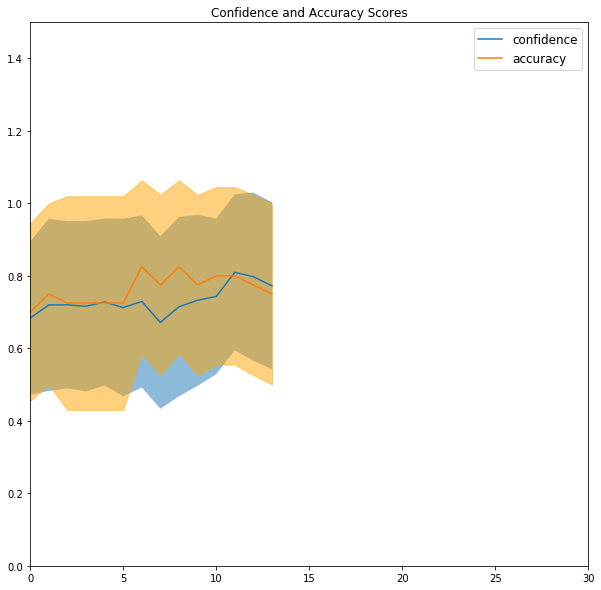

In [68]:
# Plot the trend of our evaluation
# 
# Typical training sessions last about 30 iterations so we fix xlim to that.  This
# helps to visualize training time on a consistent scale when comparing graphs 
# between different experiments.

fig = plt.figure(figsize=(10,10))
plt.plot(np.arange(len(c_score)), c_score, label="confidence")
plt.fill_between(np.arange(len(c_std)), np.array(c_score) + np.array(c_std), np.array(c_score) - np.array(c_std), alpha=0.5)
plt.plot(np.arange(len(a_score)), a_score, label="accuracy")
plt.fill_between(np.arange(len(a_std)), np.array(a_score) + np.array(a_std), np.array(a_score) - np.array(a_std), color="orange", alpha=0.5)
plt.title("Confidence and Accuracy Scores")
plt.ylim(0,1.5)
plt.xlim(0,30)
plt.legend(fontsize='large')

In [87]:
def visualize_gradcam_discrete_ppo(sess, image_path, category_index=0, num_of_actions=6):
    '''
    @inp: model session, RGB Image - np array, action_index, total number of actions 
    @return: overlayed heatmap
    '''
    img_arr = image_to_npy(image_path)
    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/observation/observation:0')
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    feed_dict = {x:[img_arr]}

    #Get he policy head for clipped ppo in coach
    model_out_layer = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    loss = tf.multiply(model_out_layer, tf.one_hot([category_index], num_of_actions))
    reduced_loss = tf.reduce_sum(loss[0])
    conv_output = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/observation/Conv2d_4/Conv2D:0')
    grads = tf.gradients(reduced_loss, conv_output)[0]
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.sum(weights * output, axis=3)

    ##im_h, im_w = 120, 160##
    rgb_img = np.array(Image.open(image_path))
    im_h, im_w = rgb_img.shape[:2]

    cam = cams[0] #img 0
    image = np.uint8(rgb_img[:, :, ::-1] * 255.0) # RGB -> BGR
    cam = cv2.resize(cam, (im_w, im_h)) # zoom heatmap
    cam = np.maximum(cam, 0) # relu clip
    heatmap = cam / np.max(cam) # normalize
    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET) # grayscale to color
    cam = np.float32(cam) + np.float32(image) # overlay heatmap
    cam = 255 * cam / (np.max(cam) + 1E-5) ##  Add expsilon for stability
    cam = np.uint8(cam)[:, :, ::-1] # to RGB

    return cam

'Confidence Score 0.772 with accuracy 0.750 for 20 images'

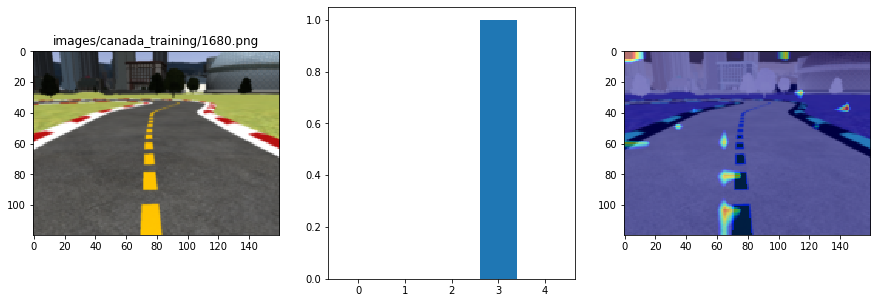

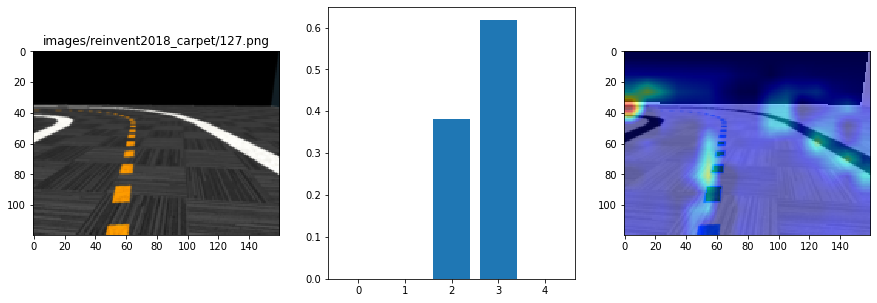

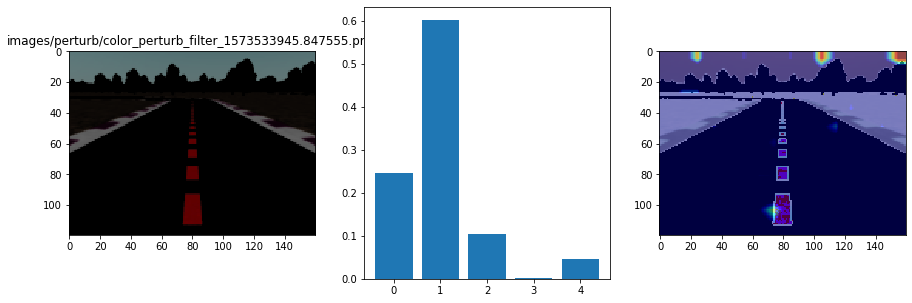

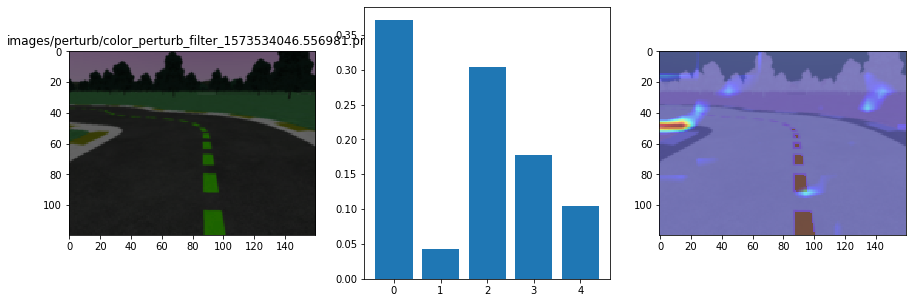

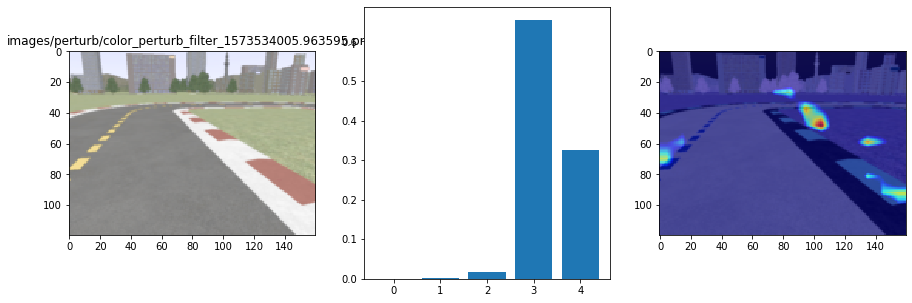

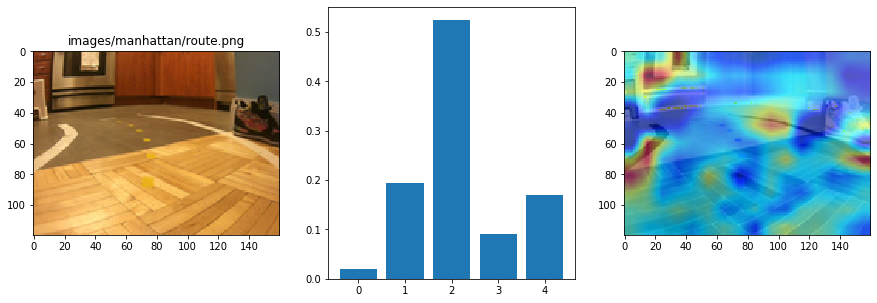

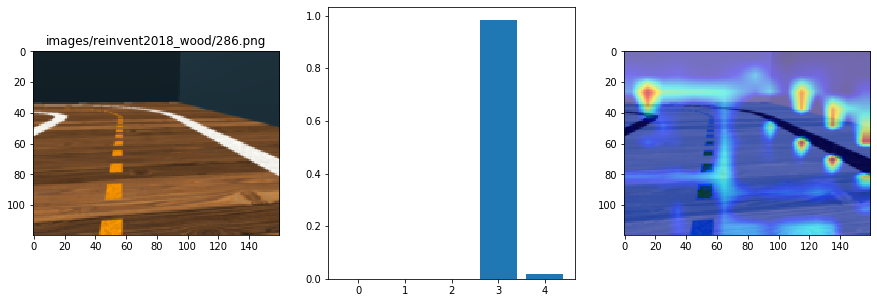

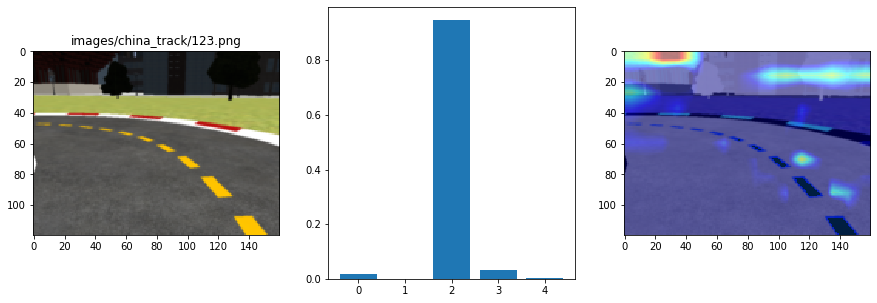

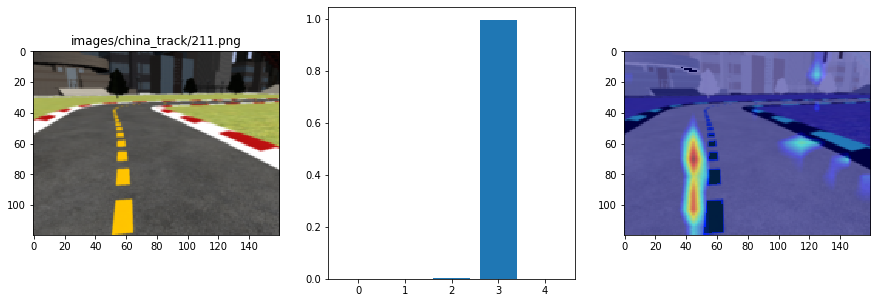

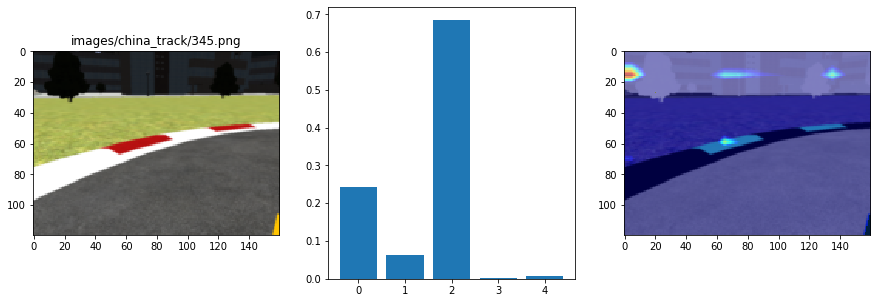

In [94]:
# Show problem images from the final iteration

last_checkpoint = len(s3_models.list_available_checkpoints(s3_bucket, s3_prefix, log_path)) - 1
_, _, _, _, results = evaluate(last_checkpoint, eval_images)

# Load the model into tensorflow
tf.reset_default_graph()
model_path = s3_models.download_checkpoint(s3_bucket, s3_prefix, "model_%d.pb" % last_checkpoint, log_path)
actions_path = s3_models.download_actions(s3_bucket, s3_prefix, log_path)
# for PPO we need the number of discrete outputs
with open(actions_path, "r") as f:
    action_space = json.load(f)['action_space']
number_of_actions = len(action_space)
#display(action_space)
# load the model
model, obs, policy = load_session(model_path)

for i in range(len(results)):
    path = results[i][0]
    probs = results[i][4]
    accuracy = results[i][5]
    if accuracy == 1.0:
        continue
    plt.figure(i, figsize=(15,5))
    plt.subplot(1, 3, 1)
    plt.title(path)
    image = np.array(Image.open(path))
    plt.imshow(image, interpolation="nearest", cmap="gray")
    plt.subplot(1, 3, 2)
    plt.bar(range(len(probs)), probs)
    plt.subplot(1, 3, 3)
    gradcam = visualize_gradcam_discrete_ppo(model, path, np.argmax(probs), number_of_actions)
    plt.imshow(gradcam)